In [1]:
from openvino.inference_engine import IENetwork, IEPlugin
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
plugin = IEPlugin(device="CPU")
plugin.add_cpu_extension(r"C:\Program Files (x86)\IntelSWTools\openvino\deployment_tools\inference_engine\bin\intel64\Release\cpu_extension_avx2.dll")

model_xml = "face-detection-adas-0001.xml"
model_bin = "face-detection-adas-0001.bin"


In [10]:
def load_model(plugin, model, weights):
    """
    Load OpenVino IR Models

    Input:
    Plugin = Hardware Accelerator
    Model = model_xml file 
    Weights = model_bin file
    
    Output:
    execution network (exec_net)
    """
    #  Read in Graph file (IR) to create network
    net = IENetwork(model, weights) 
    # Load the Network using Plugin Device
    exec_net = plugin.load(network=net)
    return net, exec_net

def image_preprocessing(n, c, h, w):
    """
    Image Preprocessing steps, to match image 
    with Input Neural nets
    
    N=1, Channel=3, Height=62, Width=62
    """
    blob = cv.resize(image, (w, h)) # Resize width & height
    blob = blob.transpose((2, 0, 1)) # Change data layout from HWC to CHW
    blob = blob.reshape((n, c, h, w))
    return blob

In [4]:
net, exec_net = load_model(plugin, model_xml,model_bin)


In [7]:
input_net = 'data'
output_net = 'detection_out'

n,c,h,w = net.inputs[input_net].shape

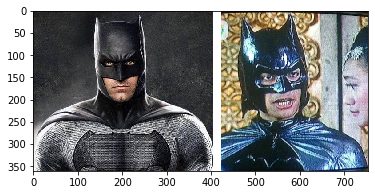

In [8]:
image = cv.imread('batman_aspal.png')
plt.imshow(image[:,:,::-1])

In [13]:
blob = image_preprocessing(n,c,h,w)
req_handle = exec_net.start_async(0, {input_net:blob})
status = req_handle.wait()
res = req_handle.outputs[output_net]

In [20]:
res[0][0][2]

array([0.        , 1.        , 0.4723253 , 0.9281104 , 0.31650114,
       0.99858993, 0.7229763 ], dtype=float32)

In [15]:
# Get Bounding Box Result
for detection in res[0][0]:
    confidence = float(detection[2]) # Face detection Confidence
    # Obtain Bounding box coordinate, +-10 just for padding
    xmin = int(detection[3] * image.shape[1] -10)
    ymin = int(detection[4] * image.shape[0] -10)
    xmax = int(detection[5] * image.shape[1] +10)
    ymax = int(detection[6] * image.shape[0] +10)

    # OpenCV Drawing Set Up
    font = cv.FONT_HERSHEY_SIMPLEX
    fontColor = (0,0,255)
    bottomLeftCornerOfText = (xmin,ymin-10)
    fontScale = 1
    lineType = 2

    # Crop Face which having confidence > 90%
    if confidence > 0.9:
        ## Draw Boundingbox
        cv.rectangle(image, (xmin, ymin), (xmax, ymax), fontColor)

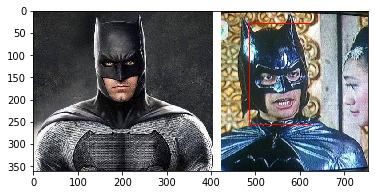

In [22]:
plt.imshow(image[...,::-1])
plt.savefig('res_batman.png')

Signature: plt.savefig(*args, **kwargs)
Docstring:
Save the current figure.

Call signature::

  savefig(fname, dpi=None, facecolor='w', edgecolor='w',
          orientation='portrait', papertype=None, format=None,
          transparent=False, bbox_inches=None, pad_inches=0.1,
          frameon=None, metadata=None)

The output formats available depend on the backend being used.

Parameters
----------

fname : str or PathLike or file-like object
    A path, or a Python file-like object, or
    possibly some backend-dependent object such as
    `matplotlib.backends.backend_pdf.PdfPages`.

    If *format* is not set, then the output format is inferred from
    the extension of *fname*, if any, and from :rc:`savefig.format`
    otherwise.  If *format* is set, it determines the output format.

    Hence, if *fname* is not a path or has no extension, remember to
    specify *format* to ensure that the correct backend is used.

Other Parameters
----------------

dpi : [ *None* | scalar > 0 | 